In [37]:
# Global parameters:
import sys
timeframe = 1 # We select the first timeframe(window) for training and inductive
undersampling_rate = 0.5
embedding_size = 64
add_additional_data = True
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy import stats
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import os
import seaborn as sns
import random
import tensorflow as tf
random.seed(123)
np.random.seed(123)
tf.compat.v1.set_random_seed(123)

import warnings
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.metrics import accuracy_score
import math

warnings.filterwarnings("ignore")

# Data Cleaning

In [38]:
parent_directory = os.path.abspath(os.path.join('.', os.pardir))
parent_directory

### load apply_info
apply_info = pd.read_csv(parent_directory + '/apply_info.csv')

### load device_info
device_info = pd.read_csv(parent_directory + './device_info.csv')

### load contacts_info and calls_info
contacts_info = pd.read_csv(parent_directory + './contacts_info.csv')

sgt_embedding = pd.read_csv('./sgt_embeddings.csv')

df = pd.merge(apply_info, contacts_info, on=['apply_user_id','apply_time'], how = "inner")
df = pd.merge(df, device_info, on=['apply_user_id','apply_time'], how = "inner")
df = pd.merge(df, sgt_embedding, left_index=True, right_index=True, how='left')
original_df = df.copy()



drop_cols = ["is_reject",
              "is_overdue",
              "overdue_day",
              "application_id_x",
              "application_id_y",
              "apply_device_id_x",
              "apply_device_id_y",
              "application_id",
              "device_id",
            "index"]

df = df.drop(columns = drop_cols)
labels = original_df.is_overdue

cols = ['num_of_applications', 'is_new_client']
df[cols] = df[cols].applymap(np.float64)
df['apply_time'] = pd.to_datetime(df['apply_time'])

from sklearn.preprocessing import LabelEncoder

device_encoder = LabelEncoder()
user_encoder = LabelEncoder()
df['apply_device_id'] = (device_encoder.fit_transform(df.apply_device_id) +len(df)+2).astype(int)
df['apply_user_id'] = (user_encoder.fit_transform(df.apply_user_id) + len(df)*4).astype(int)
df['contacts'] = (user_encoder.fit_transform(df.contacts.astype(str))).astype(int)
df['imsi'] = (user_encoder.fit_transform(df.imsi.astype(str))).astype(int)
df['phone'] = (user_encoder.fit_transform(df.phone.astype(str))).astype(int)
df['mac'] = (user_encoder.fit_transform(df.mac.astype(str))).astype(int)
df['idfv'] = (user_encoder.fit_transform(df.idfv.astype(str))).astype(int)
df['idfa'] = (user_encoder.fit_transform(df.idfa.astype(str))).astype(int)

display(df)
df.info()

,Unnamed: 0_x,apply_time,apply_user_id,num_of_applications,is_new_client,Unnamed: 0_y,contacts,Unnamed: 0,apply_device_id,imsi,...,3,4,5,6,7,21,31,41,51,61
0,0,2017-10-28 23:58:16,162182,2.0,1.0,6399,17999,6399,40220,29250,...,0,1,0,0,0,0,0,1,0,0
1,1,2017-10-28 23:59:35,145746,6.0,1.0,15200,23118,15200,49310,151,...,0,0,1,0,0,0,0,0,0,0
2,2,2017-10-28 23:59:53,169011,8.0,1.0,6400,6955,6400,48296,16711,...,0,0,0,0,1,0,0,0,0,1
3,3,2017-10-29 00:00:21,162504,1.0,1.0,15201,22745,15201,39746,23912,...,0,0,0,0,1,0,0,0,0,0
4,4,2017-10-29 00:00:38,154090,2.0,1.0,15202,12617,15202,61900,26701,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35368,35368,2017-10-31 23:55:14,156897,2.0,0.0,33920,32196,33920,60117,20558,...,0,0,1,0,0,0,0,0,0,1
35369,35369,2017-10-31 23:55:15,158635,1.0,0.0,28760,18330,28760,41874,1615,...,0,1,0,0,0,0,0,0,0,0
35370,35370,2017-10-31 23:56:09,174586,3.0,1.0,28761,13657,28761,44504,1121,...,1,0,0,0,0,0,0,0,0,1
35371,35371,2017-10-31 23:56:18,170944,2.0,0.0,28762,24413,28762,47026,17591,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35373 entries, 0 to 35372
Columns: 147 entries, Unnamed: 0_x to 61
dtypes: datetime64[ns](1), float64(124), int32(8), int64(14)
memory usage: 40.1 MB


# Get Rolling Window Function

In [39]:
def window_data(df, test_time, window_size, step_size, window_index=0):
    step_size = pd.Timedelta(hours=step_size)  
    window_size = pd.Timedelta(hours=window_size) 

    year = str(test_time.min().year)
    month = str(test_time.min().month)
    day = str(test_time.min().day)
    hour = str(test_time.min().hour)
    minute = str(test_time.min().minute)
    second = str(test_time.min().second)

    window_end = test_time.max()
    start_time = pd.Timestamp(year+'-'+month+'-'+day+' '+hour+':00:00') + window_index * step_size
    end_time = start_time + window_size


    if start_time > window_end:
        print('Window exceeds ending time')
        return None
    
    window = test_time[(test_time >= start_time) & (test_time <= end_time)]
    window_sorted = window.sort_values()

    return df.loc[window_sorted.index]

In [40]:
# train_data, inductive_data, indices = window_train_test_split(df, test_time, window_size = 12, step_size = 6, train_ratio = 0.8, window_index = 2)

# Rolling Window + Clustering

In [41]:
### get time window
test_time = df['apply_time']

### get data df
df = pd.concat([df, labels], axis=1)


## Define rolling window parameters

In [42]:
def window_train_test_split(df, test_time, window_size, step_size, train_ratio=0.8, window_index=0):
    step_size = pd.Timedelta(hours=step_size)
    window_size = pd.Timedelta(hours=window_size)

    start_time = test_time.min() + window_index * step_size
    end_time = start_time + window_size

    if start_time > test_time.max() or end_time > test_time.max():
        print(f'Window exceeds ending time at iteration {window_index}')
        return None

    window = test_time[(test_time >= start_time) & (test_time <= end_time)]
    window_sorted = window.sort_values()

    indices = window_sorted.index
    length = len(window_sorted)

    train_data = df.loc[indices[:int(length * train_ratio)]].drop(columns='apply_time')
    test_data = df.loc[indices[int(length * train_ratio):]].drop(columns='apply_time')

    return train_data, test_data, indices


In [43]:
def window_train_test_split(df, train_ratio=0.8):
    length = len(df)
    train_data = df.iloc[:int(length * train_ratio)]
    test_data = df.iloc[int(length * train_ratio):]
    return train_data, test_data


# K-Means++ _ SGT _ GraphSAGE _ Rolling Window

In [44]:
window_size = 20
step_size = 2
train_ratio = 0.8

### you have to manually input total hours of the dataset
total_hour = 72

iterations = math.floor(total_hour/step_size + 1) - window_size // step_size
iterations

27

In [45]:
def eval(predictions, proba, outputs):
    acc = np.sum(predictions == outputs) / len(predictions)
    false_neg = np.sum((predictions == 0) & (outputs == 1)) / np.sum(outputs == 1)
    
    sort_order = np.argsort(-proba)
    
    top_n_pct = [np.sum(outputs[sort_order[0:int(i * len(sort_order))]]) / \
                 np.sum(outputs) for i in [0.01, 0.03, 0.05, 0.1]]
    return acc, top_n_pct

def new_eval(predictions, proba, outputs):
    acc = np.sum(predictions == outputs) / len(predictions)
    false_neg = np.sum((predictions == 0) & (outputs == 1)) / np.sum(outputs == 1)
    
    sort_order = np.argsort(-proba)
    
    top_n_pct = [np.sum(outputs[sort_order[0:int(i * len(sort_order))]]) / \
                 int(i * len(sort_order)) for i in [0.01, 0.03, 0.05, 0.1]]
    return acc, top_n_pct

def evaluation(inductive_lbs,y_preds,predictions):
    
    auroc = roc_auc_score(inductive_lbs, y_preds)
    fpr, tpr, _ = roc_curve(inductive_lbs, predictions[::,1])
    ks = np.max(tpr-fpr)
    new_eval1 = eval(y_preds, predictions[:,1], inductive_lbs.to_numpy())
    new_eval2 = new_eval(y_preds, predictions[:,1], inductive_lbs.to_numpy())
    
    return auroc,ks,new_eval1[1],new_eval2[1]

In [69]:
# Initialize lists to store the results for all models
auc_scores_original = []
ks_scores_original = []
accuracy_scores_original = []

auc_scores_without = []
ks_scores_without = []
accuracy_scores_without = []

auc_scores_only = []
ks_scores_only = []
accuracy_scores_only = []

auc_scores_control = []
ks_scores_control = []
accuracy_scores_control = []

for i in range(iterations):
    data = window_data(df, test_time, window_size, step_size, i)

    data = data.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'])
    apply_time = data['apply_time']
    labels = data['is_overdue']
    features = data.drop(columns=['apply_time', 'is_overdue']).copy()

    # Split data into training and test sets
    train_data, inductive_data = window_train_test_split(features, train_ratio=0.8)
    train_labels = labels[train_data.index]

    if len(train_labels.unique()) < 2:
        # Randomly set one row to have the opposite class
        random_index = random.choice(train_labels.index)
        train_labels[random_index] = 1 - train_labels[random_index]
        print(f'Observation {random_index} label is changed to the opposite; Train set does not have both classes to train.')

    test_labels = labels[inductive_data.index]
    
    # Apply undersampling to the training set
    print("An undersampling rate of", undersampling_rate, "is applied.")
    train_data['apply_id'] = train_data.index
    undersample = RandomUnderSampler(sampling_strategy=undersampling_rate, replacement=False)
    X, y = undersample.fit_resample(train_data, train_labels)
    train_data = X.drop(columns=['apply_id'])
    train_data.index = X['apply_id']
    train_labels = y
    train_labels.index = train_data.index
    print('The new distribution for the train set is:\n', train_labels.value_counts())

    # Prepare the graph data as you did before
    transaction_node_data = train_data.drop(columns=["apply_user_id", "apply_device_id"])
    client_node_data = pd.DataFrame([1]*len(train_data.apply_user_id.unique())).set_index(train_data.apply_user_id.unique())
    merchant_node_data = pd.DataFrame([1]*len(train_data.apply_device_id.unique())).set_index(train_data.apply_device_id.unique())

    graphsage_nodes = {"client": train_data.apply_user_id, "merchant": train_data.apply_device_id, "transaction": train_data.index}
    graphsage_edges = [zip(train_data.apply_user_id, train_data.index), zip(train_data.apply_device_id, train_data.index)]
    graphsage_features = {"transaction": transaction_node_data, "client": client_node_data, "merchant": merchant_node_data}

    graphsage_graph = GraphConstruction(graphsage_nodes, graphsage_edges, graphsage_features)
    S = graphsage_graph.get_stellargraph()

    num_samples = [2, 32]
    embedding_node_type = "transaction"

    # Train embeddings
    hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
    trained_hinsage_model, graphsage_train_emb = hinsage.train_hinsage(S, list(train_data.index), train_labels, batch_size=50, epochs=5)

    pd.options.mode.chained_assignment = None

    # Prepare inductive graph data
    train_data['apply_id'] = train_data.index
    inductive_data['apply_id'] = inductive_data.index
    inductive_graph_data = pd.concat((train_data, inductive_data))
    inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['apply_id']).drop("apply_id", axis=1)

    transaction_node_data = inductive_graph_data.drop("apply_user_id", axis=1).drop("apply_device_id", axis=1)
    client_node_data = pd.DataFrame([1]*len(inductive_graph_data.apply_user_id.unique())).set_index(inductive_graph_data.apply_user_id.unique())
    merchant_node_data = pd.DataFrame([1]*len(inductive_graph_data.apply_device_id.unique())).set_index(inductive_graph_data.apply_device_id.unique())

    nodes = {"client": inductive_graph_data.apply_user_id, "merchant": inductive_graph_data.apply_device_id, "transaction": inductive_graph_data.index}
    edges = [zip(inductive_graph_data.apply_user_id, inductive_graph_data.index), zip(inductive_graph_data.apply_device_id, inductive_graph_data.index)]
    features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

    graphsage_graph = GraphConstruction(nodes, edges, features)
    S = graphsage_graph.get_stellargraph()

    # Inductive embeddings
    graphsage_inductive_emb = hinsage.inductive_step_hinsage(S, trained_hinsage_model, inductive_data.index, batch_size=50)
    
    # Four sets of train and inductive features, including the control group
    train_features_original = pd.concat([train_data.drop(['apply_user_id', 'apply_device_id'], axis=1), graphsage_train_emb], axis=1)
    train_features_without = train_features_original.drop(columns=['is_new_client'])
    train_features_only = train_data[['is_new_client']].copy()
    train_features_control = train_data[['num_of_applications']].copy()  # Control group

    inductive_features_original = pd.concat([inductive_data.drop(['apply_user_id', 'apply_device_id'], axis=1), graphsage_inductive_emb], axis=1)
    inductive_features_without = inductive_features_original.drop(columns=['is_new_client'])
    inductive_features_only = inductive_data[['is_new_client']].copy()
    inductive_features_control = inductive_data[['num_of_applications']].copy()  # Control group

    train_features_original.columns = range(len(train_features_original.columns))
    inductive_features_original.columns = range(len(inductive_features_original.columns))
    train_features_without.columns = range(len(train_features_without.columns))
    inductive_features_without.columns = range(len(inductive_features_without.columns))

    # Fit XGBoost models
    xgb_model_original = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, tree_method='gpu_hist', eval_metric='logloss')
    xgb_model_without = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, tree_method='gpu_hist', eval_metric='logloss')
    xgb_model_only = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, tree_method='gpu_hist', eval_metric='logloss')
    xgb_model_control = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, tree_method='gpu_hist', eval_metric='logloss')  # Control group model

    xgb_model_original.fit(train_features_original, train_labels)
    xgb_model_without.fit(train_features_without, train_labels)
    xgb_model_only.fit(train_features_only, train_labels)
    xgb_model_control.fit(train_features_control, train_labels)  # Train the control model

    # Predictions and evaluations for all four models
    for model, inductive_features, auc_list, ks_list, accuracy_list, label in [
        (xgb_model_original, inductive_features_original, auc_scores_original, ks_scores_original, accuracy_scores_original, 'original'),
        (xgb_model_without, inductive_features_without, auc_scores_without, ks_scores_without, accuracy_scores_without, 'without "is_new_client"'),
        (xgb_model_only, inductive_features_only, auc_scores_only, ks_scores_only, accuracy_scores_only, 'only "is_new_client"'),
        (xgb_model_control, inductive_features_control, auc_scores_control, ks_scores_control, accuracy_scores_control, 'control ("num_of_applications")')
    ]:
        predictions = model.predict(inductive_features)
        xgb_predictions = model.predict_proba(inductive_features)
        xgb_y_pred = model.predict(inductive_features)

        fpr, tpr, thresholds = roc_curve(test_labels, xgb_predictions[:, 1])
        auc = roc_auc_score(test_labels, xgb_predictions[:, 1])
        ks = max(tpr - fpr)
        accuracy = accuracy_score(test_labels, predictions)  # Calculate accuracy

        auc_list.append((i, auc))
        ks_list.append((i, ks))
        accuracy_list.append((i, accuracy))  # Store accuracy

        print(f'Window: {i+1} ({label} model), AUC: {auc:.4f}, KS: {ks:.4f}, Accuracy: {accuracy:.4f}')


An undersampling rate of 0.5 is applied.
The new distribution for the train set is:
 0    630
1    315
Name: is_overdue, dtype: int64
Epoch 1/5
16/16 [==============================] - 1s 18ms/step - loss: 0.5764 - val_loss: 1.1579
Epoch 2/5
16/16 [==============================] - 0s 9ms/step - loss: 0.4891 - val_loss: 1.3972
Epoch 3/5
16/16 [==============================] - 0s 10ms/step - loss: 0.4657 - val_loss: 1.5305
Epoch 4/5
16/16 [==============================] - 0s 9ms/step - loss: 0.4568 - val_loss: 1.6106
Epoch 5/5
53/53 [==============================] - 1s 6ms/step
Window: 1 (original model), AUC: 0.7457, KS: 0.4307, Accuracy: 0.7876
Window: 1 (without "is_new_client" model), AUC: 0.5055, KS: 0.0708, Accuracy: 0.7714
Window: 1 (only "is_new_client" model), AUC: 0.7617, KS: 0.5233, Accuracy: 0.6338
Window: 1 (control ("num_of_applications") model), AUC: 0.5198, KS: 0.0468, Accuracy: 0.9622
An undersampling rate of 0.5 is applied.
The new distribution for the train set is:

In [70]:
# Create the DataFrame with AUC, KS, and Accuracy, including the control group
data = {
    ('Original', 'AUC'): [x[1] for x in auc_scores_original],
    ('Original', 'KS'): [x[1] for x in ks_scores_original],
    ('Original', 'Accuracy'): [x[1] for x in accuracy_scores_original],
    ('Without is_new_client', 'AUC'): [x[1] for x in auc_scores_without],
    ('Without is_new_client', 'KS'): [x[1] for x in ks_scores_without],
    ('Without is_new_client', 'Accuracy'): [x[1] for x in accuracy_scores_without],
    ('With only is_new_client', 'AUC'): [x[1] for x in auc_scores_only],
    ('With only is_new_client', 'KS'): [x[1] for x in ks_scores_only],
    ('With only is_new_client', 'Accuracy'): [x[1] for x in accuracy_scores_only],
    ('Control (num_of_applications)', 'AUC'): [x[1] for x in auc_scores_control],
    ('Control (num_of_applications)', 'KS'): [x[1] for x in ks_scores_control],
    ('Control (num_of_applications)', 'Accuracy'): [x[1] for x in accuracy_scores_control],
}

# Create the DataFrame
df_results = pd.DataFrame(data)

# Insert the Iteration column
df_results.insert(0, 'Iteration', [x[0] for x in auc_scores_original])

# Display the DataFrame


In [94]:
display(df_results)
df_results.mean(axis=0)

Iteration  Original                     Without is_new_client            \
                   AUC        KS  Accuracy                   AUC        KS   
0          0  0.745656  0.430723  0.787604              0.505491  0.070833   
1          1  0.745802  0.433767  0.708185              0.537059  0.119841   
2          2  0.746860  0.424332  0.754571              0.523269  0.108970   
3          3  0.726252  0.382076  0.813156              0.500011  0.076973   
4          4  0.755884  0.420188  0.753726              0.515294  0.086561   
5          5  0.793806  0.470718  0.742779              0.494238  0.059535   
6          6  0.747671  0.430498  0.805391              0.468443  0.104436   
7          7  0.753337  0.516609  0.896590              0.457351  0.066806   
8          8  0.713588  0.459115  0.822727              0.523787  0.108061   
9          9  0.641450  0.333631  0.702140              0.474416  0.092725   
10        10  0.719298  0.411763  0.713529              0.567992  0.151210   
11        11  0.725121  0.456713  0.760587              0.525849  0.126693   
12        12  0.766703  0.426614  0.769639              0.530208  0.095080   
13        13  0.735804  0.413148  0.790080              0.522736  0.129541   
14        14  0.762566  0.494880  0.749274              0.568806  0.143403   
15        15  0.728909  0.440552  0.672986              0.477127  0.068942   
16        16  0.690779  0.366631  0.781118              0.470246  0.091910   
17        17  0.714743  0.420420  0.755848              0.451071  0.060561   
18        18  0.710535  0.438326  0.764840              0.440507  0.012775   
19        19  0.692013  0.360130  0.725786              0.490182  0.069221   
20        20  0.687467  0.394507  0.791281              0.532135  0.122672   
21        21  0.706108  0.388941  0.778552              0.513295  0.081747   
22        22  0.711755  0.423938  0.742673              0.510685  0.064674   
23        23  0.717735  0.405826  0.770762              0.518481  0.087451   
24        24  0.743724  0.423823  0.794098              0.526226  0.099549   
25        25  0.746122  0.439103  0.773125              0.512724  0.108974   
26        26  0.712934  0.438037  0.829518              0.502860  0.127534   

             With only is_new_client                      \
    Accuracy                     AUC        KS  Accuracy   
0   0.771353                0.761665  0.523331  0.633787   
1   0.648754                0.732731  0.465462  0.970819   
2   0.671589                0.730380  0.460760  0.625527   
3   0.765570                0.720641  0.441282  0.642057   
4   0.667140                0.727580  0.455161  0.634138   
5   0.750976                0.751880  0.503760  0.636222   
6   0.818182                0.769638  0.539275  0.650982   
7   0.875138                0.751342  0.502684  0.649615   
8   0.861364                0.677762  0.355524  0.417045   
9   0.699826                0.696482  0.392964  0.483516   
10  0.770588                0.729869  0.459739  0.510588   
11  0.692264                0.723771  0.447541  0.597967   
12  0.710722                0.743743  0.487486  0.958068   
13  0.848697                0.716879  0.433759  0.964429   
14  0.705227                0.713404  0.426808  0.969022   
15  0.511374                0.724092  0.448185  0.973460   
16  0.764678                0.716162  0.432325  0.972757   
17  0.726608                0.759009  0.518018  0.973684   
18  0.801941                0.751171  0.502343  0.972032   
19  0.819497                0.704935  0.409870  0.447170   
20  0.798547                0.702423  0.404846  0.965654   
21  0.685933                0.730985  0.461971  0.963092   
22  0.765547                0.717723  0.435446  0.969264   
23  0.903226                0.697766  0.395532  0.969801   
24  0.797377                0.711344  0.422687  0.971148   
25  0.821250                0.707051  0.414103  0.975000   
26  0.817470                0.709805  0.419610  0.980723   


Iteration                                  13.000000
Original                       AUC          0.727504
                               KS           0.423889
                               Accuracy     0.768539
Without is_new_client          AUC          0.505944
                               KS           0.093951
                               Accuracy     0.758179
With only is_new_client        AUC          0.725194
                               KS           0.450388
                               Accuracy     0.795465
Control (num_of_applications)  AUC          0.552741
                               KS           0.119202
                               Accuracy     0.965305
dtype: float64

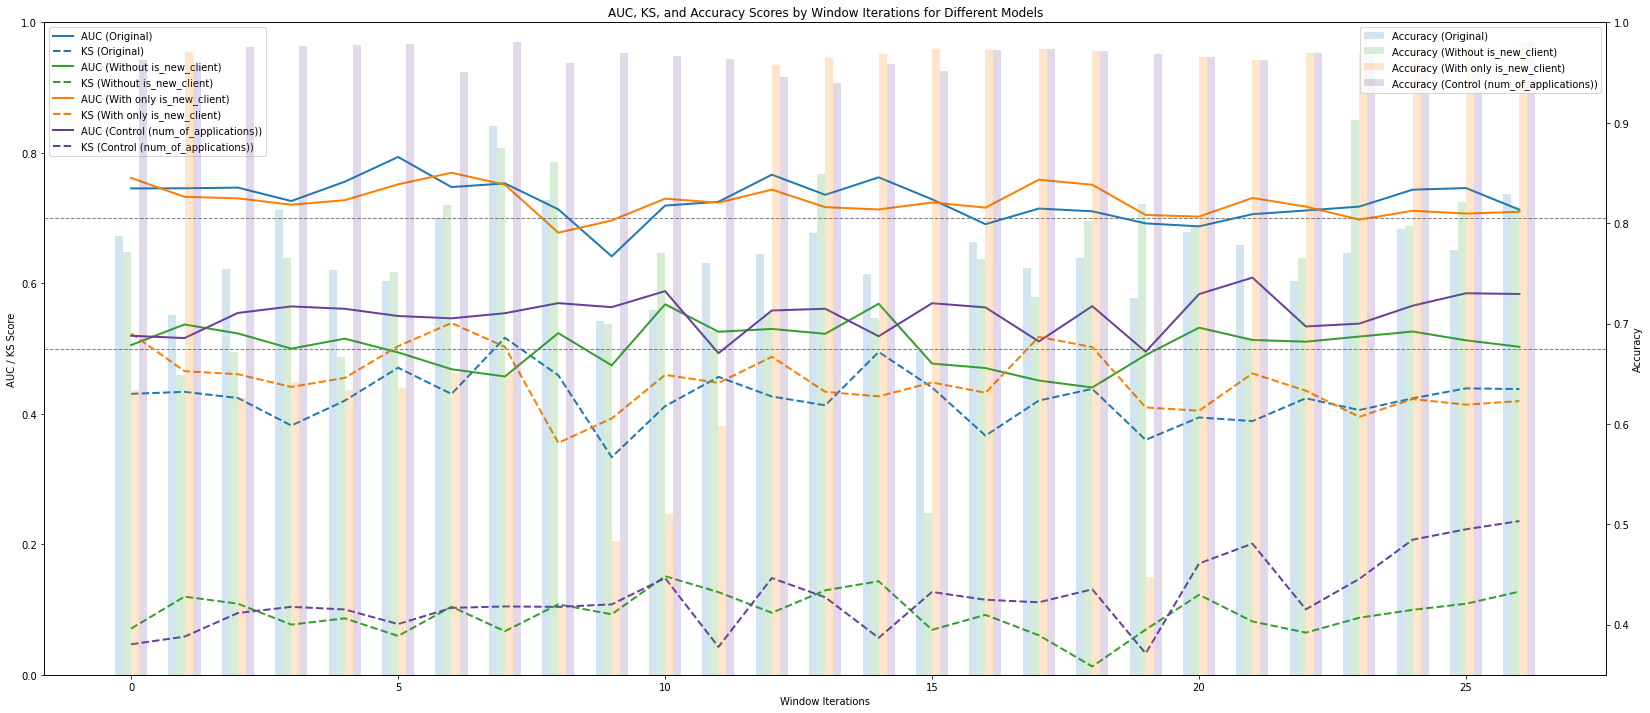

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Adjust 'iteration_range' based on the actual data length
iterations = len(auc_scores_original)  # Adjust this to match the length of your data
iteration_range = np.arange(iterations)  # Create a range of iteration numbers based on the correct length

# Get the color palette
colors = sns.color_palette(palette='Paired', n_colors=10)  # Adjust to get more colors

# Darken the line colors for better readability
darkened_colors = [mcolors.to_rgba(colors[i], alpha=None) for i in [1, 3, 7, 9]]

# Assign colors to each group (same color for both AUC and KS)
color_pairs = darkened_colors  # Using the darkened colors for lines

# Plotting
fig, ax1 = plt.subplots(figsize=(28, 12))
ax1.set_ylim(0, 1)  # Adjust the y-limit according to your data

# Add horizontal lines at 0.5 and 0.7
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1)
ax1.axhline(0.7, color='gray', linestyle='--', linewidth=1)

# Plot AUC and KS values for each model on the left y-axis
models = ['Original', 'Without is_new_client', 'With only is_new_client', 'Control (num_of_applications)']
auc_values = [auc_scores_original, auc_scores_without, auc_scores_only, auc_scores_control]
ks_values = [ks_scores_original, ks_scores_without, ks_scores_only, ks_scores_control]
accuracy_values = [accuracy_scores_original, accuracy_scores_without, accuracy_scores_only, accuracy_scores_control]

for model_name, auc, ks, color in zip(models, auc_values, ks_values, color_pairs):
    ax1.plot(iteration_range, [x[1] for x in auc], label=f'AUC ({model_name})', linestyle='-', linewidth=2, color=color, zorder=2)
    ax1.plot(iteration_range, [x[1] for x in ks], label=f'KS ({model_name})', linestyle='--', linewidth=2, color=color, zorder=2)

# Create a secondary y-axis to plot the accuracy as bars
ax2 = ax1.twinx()
ax2.set_ylim(0.4, 1)
bar_width = 0.15  # Adjust bar width for 4 models
bar_positions = iteration_range - (1.5 * bar_width)  # Adjust bar positions for better alignment

for i, (model_name, accuracy, color) in enumerate(zip(models, accuracy_values, color_pairs)):
    ax2.bar(bar_positions + i * bar_width, [x[1] for x in accuracy], bar_width, alpha=0.2, label=f'Accuracy ({model_name})', color=color, zorder=1)

# Adding legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Labels and title
ax1.set_xlabel('Window Iterations')
ax1.set_ylabel('AUC / KS Score')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0.35, 1)

plt.title('AUC, KS, and Accuracy Scores by Window Iterations for Different Models')

plt.show()
